In [1]:
import numpy as np
import tonic
import tonic.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
import matplotlib.patches as patches
from tqdm.notebook import tqdm

In [2]:
import sys
sys.path.append("./mnist_sg_cnn")

In [3]:
import utils
import snn_utils
import base_model
import lenet_decolle_model

In [4]:
dir = "/media/user/EVIMO/raw/imo/eval/scene15_dyn_test_01/left_camera/ground_truth_000000"
sensor_size = [640, 480, 2]
batch_size = 4
num_bins_per_frame = 16 # T = 100
framerate = 200
epochs=20

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
class EVIMO(Dataset):
    def __init__(self,
                 dir: str,
                 item_to_find: int,
                 num_bins_per_frame: int,
                 #start_idx: int,
                ):
        self.dir = dir
        self.item_to_find = item_to_find
        self.num_bins_per_frame = num_bins_per_frame
        self.length = np.load(self.dir + "/length.npy")
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        if self.item_to_find in item["objs_in_mask"]:
            target = np.asarray([0, 1])
        else:
            target = np.asarray([1, 0])

        #target = np.tile(target, (self.num_bins_per_frame, 1))
        #print(item["events"].dtype)
        
        events = np.asarray(item["events"])
        #target = target

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame)
                                      ])

        # #transform = transforms.ToFrame(sensor_size=sensor_size, )
        bins = frame_transform(events)

        #return {"data": events, "targets": target}
        return bins, target

    def __len__(self) -> int:
        return self.length # - self.start_idx
    
    

In [6]:
tonic_dataset = EVIMO(dir="./data/EVIMO/left_cam/scene13_test5", item_to_find=23, num_bins_per_frame=num_bins_per_frame)

In [7]:
bins, target = tonic_dataset[0]
bins.shape

(16, 1, 480, 640)

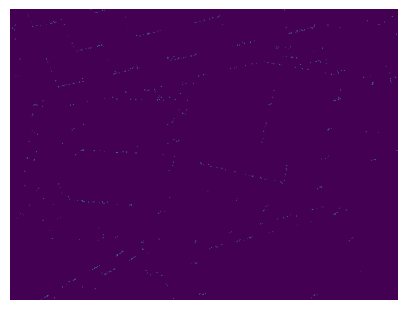

In [8]:
ani = tonic.utils.plot_animation(bins)

In [9]:
%timeit -o -r 1 tonic_dataset[0]

28.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


<TimeitResult : 28.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)>

157 ms ± 4.12 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)

In [10]:
import os

cache_dir = "./data/EVIMO/cache"
targets = []
num_ones = 0

if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

for i in range(len(tonic_dataset)):
    events, target = tonic_dataset[i]
    targets.append(target)
    np.save(cache_dir+f"/{i}_events", events)

np.save(cache_dir+f"/targets", np.asarray(targets))
np.save(cache_dir+f"/length", len(tonic_dataset))
    

KeyboardInterrupt: 

In [11]:
class CachedEVIMODataset(Dataset):
    def __init__(self, 
                dir: str):
        self.dir = dir
        
        self.length = np.load(self.dir+f"/length.npy")
        self.targets = np.load(self.dir+f"/targets.npy")

    def __getitem__(self, index):
        events = np.load(self.dir+f"/{i}_events.npy")
        return events, self.targets[index]

    def __len__(self):
        return self.length

In [12]:
dataset = CachedEVIMODataset(dir=cache_dir)

In [13]:
%timeit -o -r 1 dataset[0]

6.27 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


<TimeitResult : 6.27 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)>

20.7 ms ± 1.09 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)

In [ ]:
events, target = dataset[0]

In [ ]:
target.argmax()

num_ones = 0
#targ_set = set()

for i in range(0, len(dataset)):
    _, target = dataset[i]
    #print(target.argmax())
    if target.argmax() == 1:
        num_ones += 1
        #targ_set.add(a)
    

In [ ]:
num_ones / len(dataset)

In [14]:
trainloader = DataLoader(tonic_dataset, batch_size=batch_size, shuffle=False) # collate_fn=tonic.collation.PadTensors(),
#test_trainloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
#for i_batch, sample_batched in enumerate(trainloader):
#    print(i_batch, sample_batched['data'].size(), sample_batched['target'].size())

In [16]:
datait = iter(trainloader)
bins, targets = next(datait)

In [17]:
bins.shape

torch.Size([4, 16, 1, 480, 640])

In [18]:
targets.shape

torch.Size([4, 2])

In [19]:
data, target = next(iter(trainloader))

loss = torch.nn.SmoothL1Loss()

def decolle_loss(r, s, tgt):
    loss_tv = 0
    for i in range(len(r)):
        if r[i].shape != tgt.shape:
            print(f"Loss Readout shape : {r[i].shape}")
            print(f"Loss Target shape : {tgt.shape}")
        loss_tv += loss(r[i],tgt) 
    return loss_tv


convnet_sg = lenet_decolle_model.LenetDECOLLE(out_channels=2,
                    Nhid=[64, 128], #Number of convolution channels
                    Mhid=[256],
                    kernel_size=[8, 16],
                    pool_size=[4, 8],
                    input_shape=[1, 480, 640],  # data.shape[1:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=2,
                    num_mlp_layers=1,
                    lc_ampl=0.5).to(device)

#net = lenet_decolle_model.LenetDECOLLE(Nhid=[1,8],Mhid=[32,64],out_channels=2, input_shape=[2, 480, 640]).to(device)

#convnet_sg

data_d = data.to(device)
target_d = target.to(device)
convnet_sg.init_parameters(data_d) # Modifies readout dim

LAYER SIZE: 1210944
STDV: 0.000454368247933539
LAYER SIZE: 34048
STDV: 0.002709718654762875
LAYER SIZE: 256
STDV: 0.03125


In [20]:
data_d.shape

torch.Size([4, 16, 1, 480, 640])

In [21]:
target_d.shape

torch.Size([4, 2])

In [24]:
from tqdm.notebook import tqdm

opt_conv = torch.optim.Adamax(convnet_sg.get_trainable_parameters(), lr=1e-9, betas=[0., .95])
for e in range(epochs):        
    error = []
    accuracy=[]
    for data, label in tqdm(iter(trainloader), desc=f"Epoch {e}"):
        convnet_sg.train()
        loss_hist = 0
        data_d = data.to(device, dtype=torch.float)
        label_d = label.to(device)
        convnet_sg.init(data_d, burnin=10)
        readout = 0

        #print(label_d)
        #print(label_d.shape)
        #break

        data_d = data_d.transpose(0, 1)
        
        for n in range(num_bins_per_frame):
           # print(f"Data shape: {data_d[n].shape}, overall: {data_d.shape}")
            st, rt, ut = convnet_sg.forward(data_d[n])
            #print("Readout")
            #print(len(rt), rt[0].shape, rt[1].shape, rt[2].shape)
            #print(f"Label: {label_d[n].shape} overall {label_d.shape}")
            #print(label_d[n].shape)
            #print(label_d[n])
            loss_tv = decolle_loss(rt, st, label_d)
            loss_tv.backward()
            opt_conv.step()
            opt_conv.zero_grad()
            loss_hist += loss_tv
            print(rt)
            print(rt[-1])
            readout += rt[-1]
            print(readout)
        error += (readout.argmax(axis=1)!=label_d.argmax(axis=1)).float()
        accuracy+=(readout.argmax(axis=1)==label_d.argmax(axis=1)).float()
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)     
    print('Epoch', e, 'Loss', loss_hist.data)
    PATH = './mnist_network_sg_conv.pth'
    torch.save(convnet_sg.state_dict(), PATH)

Epoch 0:   0%|          | 0/120 [00:00<?, ?it/s]

[tensor([[-0.3657,  0.1922],
        [-0.1385, -0.1003],
        [-0.1654, -0.2374],
        [-0.0819, -0.1092]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[-0.1582,  1.2147],
        [ 0.1850,  1.2803],
        [-0.2844,  1.2766],
        [ 0.1006,  0.9054]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.3028, 0.4670],
        [0.2242, 0.4168],
        [0.1537, 0.4155],
        [0.2442, 0.3245]], device='cuda:0', grad_fn=<AddmmBackward0>)]
tensor([[0.3028, 0.4670],
        [0.2242, 0.4168],
        [0.1537, 0.4155],
        [0.2442, 0.3245]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.3028, 0.4670],
        [0.2242, 0.4168],
        [0.1537, 0.4155],
        [0.2442, 0.3245]], device='cuda:0', grad_fn=<AddBackward0>)
[tensor([[-0.1044,  0.1879],
        [-0.1296,  0.1187],
        [-0.3328, -0.1734],
        [ 0.0996, -0.3822]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[ 0.3466, -0.4593],
        [ 0.3427, -0.2044],
        [ 0.0792, -0.1132],


KeyboardInterrupt: 

In [ ]:
opt_conv = torch.optim.Adamax(convnet_sg.get_trainable_parameters(), lr=1e-6, betas=[0., .95])

# Their data_d is T, batchsize, pol, x, y (16, 4, 1, 28, 28)
# Mine is batchsize, T, pol, x,y

for e in range(epochs):        
    error = []
    accuracy=[]
    for data, label in tqdm(iter(trainloader), desc=f"Epoch {e}"):

        #if label.shape[0] != 4:
            #print(f"last entry")
            #break
        
        convnet_sg.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        convnet_sg.init(data_d, burnin=10)
        readout = 0

        data_d = data_d.transpose(0, 1)
        
        #print(label_d.shape)
        #print(label_d)
        
        for n in range(num_bins_per_frame):
            # CORRECT: Data shape: torch.Size([4, 2, 480, 640]), overall: torch.Size([8, 4, 2, 480, 640])
            #print(f"Data shape: {data_d[n].shape}, overall: {data_d.shape}")
            #print(data_d[n])
            
            st, rt, ut = convnet_sg.forward(data_d[n])
            #print("Readout")
            #print(len(rt), rt[0].shape, rt[1].shape, rt[2].shape)
            #print(rt[-1].shape)

            # CORRECT: Label shape: torch.Size([4, 2]), overall: torch.Size([8, 4, 2])
            #print(f"Label shape: {label_d[n].shape}, overall: {label_d.shape}")
            #print(label_d[n].shape, label_d[n])
            
            #print(label_d)
            #break
            loss_tv = decolle_loss(rt, st, label_d)
            
            loss_tv.backward()
            opt_conv.step()
            opt_conv.zero_grad()
            loss_hist += loss_tv
            readout += rt[-1]

        #print(f"Readout: {readout}")
        #error += (readout.argmax(axis=1)!=label_d.argmax(axis=1)).float()
        #accuracy+=(readout.argmax(axis=1)==label_d.argmax(axis=1)).float()

        # SEEM CORRECT
        argmaxed_readout = readout.argmax(axis=1)
        #print("argmaxeds")
        #print(argmaxed_readout)
        #print(label_d)
        #print(label_d[-1])
        #print(label_d.argmax(axis=1))
        argmaxed_label = label_d.argmax(axis=1)
        #print(argmaxed_label)
        #break
        #print("argmaxed readout")
        #print(argmaxed_readout)
        #print("argmaxed label")
        #print(argmaxed_label)
        error += (argmaxed_readout!=argmaxed_label).float()
        accuracy+=(argmaxed_readout==argmaxed_label).float()
        #print(f"Accuracy: {accuracy}")
        #break
        
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)     
    print('Epoch', e, 'Loss', loss_hist.data)
    PATH = './EVIMO_class_cnn.pth'  
    torch.save(convnet_sg.state_dict(), PATH)

In [ ]:
type(loss_tv)

In [ ]:
error = []
accuracy=[]
y_pred = []
y_true = []
#convnet_sg.requires_init = True
for item in iter(batched_trainloader):
    #print("Item")
    #print(item)
    data = item['data']
    label = item['target']
    if label.shape[0] != 4:
        #print(f"last entry: {label}")
        break

    #print("earliest label")
    #print(label)
    #print(label.shape)

    
    loss_hist = 0
    data_d = data.to(device)
    label_d = label.to(device)
    print(f"data_d shape: {data_d.shape}")
    print(f"data_d_tranpose shape: {data_d.transpose(0,1).shape}")
    print(f"Len convnet: {len(convnet_sg)}")
    print(f"data init shape: {data_d.transpose(0,1)[:, 0, :, :].shape}")
    print(f"Test data shape: {data_d[0].shape}")
    
    convnet_sg.init_evimo(data_d)
    readout = 0
    with torch.no_grad():
        #for i in range(0, len(data_d)):
        #d = data_d[i:i+1]
        
        #print(d.shape)
        
        st, rt, ut = convnet_sg.forward(data_d)

        
        
        print(f"Label shape: {label_d.shape}")
        print("Readout")
        print(rt)
        print(rt[0].shape)

        #print("labels")
        #print(label_d)
        #print(label_d.shape)
        
        
        loss_tv = decolle_loss(rt, st, label_d)
        
        
        loss_hist += loss_tv
        readout += rt[-1]
        print(f"Readout: {readout}")
        output = (readout.argmax(axis=1)).data.cpu().numpy()
        print(f"Output: {output}")
        y_pred.extend(output)
        #labels = label_d.argmax(axis=1)
        print(f"Labels: {label_d}")
        labels = (label_d.argmax(axis=1)).data.cpu().numpy()
        print(f"Labels: {labels}")
        y_true.extend(labels)
        accuracy+=(readout.argmax(axis=1)==label_d.argmax(axis=1)).float()
        error += (readout.argmax(axis=1)!=label_d.argmax(axis=1)).float()
        break
        
print('Testing Error', torch.mean(torch.Tensor(error)).data)
print('Testing accuracy', torch.mean(torch.Tensor(accuracy)).data)

In [ ]:
print(y_true)
print(y_pred)

In [ ]:
"""
convnet_sg = lenet_decolle_model.LenetDECOLLE( out_channels=2,
                    Nhid=[16,32], #Number of convolution channels
                    Mhid=[64],
                    kernel_size=[7],
                    pool_size=[2,2],
                    input_shape=[2, 480, 640],  # data.shape[1:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=2,
                    num_mlp_layers=1,
                    lc_ampl=.5).to(device)

"""

In [ ]:
net = lenet_decolle_model.LenetDECOLLE(Nhid=[16,32],Mhid=[64],out_channels=2, pool_size=[2,2], num_conv_layers=2, num_mlp_layers=1, lc_ampl=.5, input_shape=[2, 480, 640])
d = torch.zeros([1, 2, 480, 640])
print(d.shape)
st, rt, ut = net.forward(d)
print(rt[0].shape)

In [ ]:
print(rt)

In [ ]:
target = torch.zeros([1, 2])
target

In [ ]:
loss_tv = decolle_loss(rt, st, target)